# The final project "Text classification - reviews score prediction" for Bootcamp Data Science PRO by Sages (Kodołamacz)
# Joanna Czarnocka, December 2022

## Intoduction

In this project a challenging task of English text classification based on online books reviews will be undertaken which is an example attempt to solve a NLP problem. 
It is useful business exercise that can be applied to automatic comments/reviews scoring which could be afterwards used for books demand for online shops prediction. Let's notice that we want have a tool that is universal - produces scoring prediction for review or it's summary and without any other supporting variables like  book title or price. Data for modelling have been taken from the Data Science competition portal - Kaggle: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews , they are in csv format and contain textual book reviews from Amazon. Machine learning techniques (classification models building, training and using for prediction) will be used to perform task of reviews scoring of unknown reviews texts. Due to RAM problems (experienced even on free version of **Colab**) dataset will be limited from 3,000,000 records to 50,000 records. Other approaches could be also taken to increase quality of models and keep huge number of records (application of **Colab Pro** or core techniques).

Frequent problems on Colab with these amount of data even after limitation of records (in Polish): "Twoja sesja uległa awarii po użyciu całej dostępnej pamięci RAM. Jeśli chcesz używać środowisk wykonawczych wykorzystujących dużą ilość pamięci RAM, sprawdź wersję **Colab Pro.**", in English: "Your session crashed after using all available RAM. If you want to use RAM-intensive runtimes, check out **Colab Pro**". This is reason why we don't include full models' trianing results since it was difficult to repeat them all after final notebook's modifications.

### Libraries imports and downloads

During our struggle to obtain better accuracy results we used the following models - classifiers:
- Decision Trees
- Random Forest
- Logistic Regression
- XGBoost
- Neural Networks (Normal and Recursive with Embeddings)
- BERT Embeddings

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import string
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Constants definitions

In the project we use the following limitations and constants:

In [58]:
RANDOM_SEED = 22 # to fix random state of operations based on probability
NUMBER_OF_EPOCHS = 20  # maximum number of epochs of neural network models - used apart from ealy stopping mechanism
CLASS_SIZE = 10000 # number of records for each scoring class (maximum available to keep balanced dataset is 108,935)
FIRST_WORDS_NUMBER = 100 # number of words kept in review for modelling due to RAM limitations

Setting for Colab computations (dataset Books_rating.csv from Kaggle needs to be loaded to you google disk and permission to use the disk should be given):

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data exploratory analysis and preparation for modelling

Let us import the data from csv file (downloaded manually from the portal kaggle) to pandas data frame for further analysis and trasformations:

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Books_rating.csv") # for Colab
#df = pd.read_csv("data/Books_rating.csv") # for local disk

We see the structure of the dataset:

In [6]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


The columns it the imported dataset are the following:
- Id - identifier of a book
- Title - title of a book
- Price - price of a book
- User_id - identified of user
- profileName - name of the book's review profile
- review/helfullness - helpfulness rating of the review
- review/score - rating from 0 to 5 for the book - this is the **target variable** (predicted, dependent variable)
- review/time - time of given the review
- review/summary - the summary of text review
- review/text - the full text of a review - this is **main independent variable**, which will be used as an input for scoring prediction

Let us see the dataset statistics - the dataset contains 3,000,000 observations (records) which could be more than enough for machine learning purposes:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [8]:
df.describe()

,Price,review/score,review/time
count,481171.000000,3.000000e+06,3.000000e+06
mean,21.762656,4.215289e+00,1.132307e+09
std,26.206541,1.203054e+00,1.493202e+08
min,1.000000,1.000000e+00,-1.000000e+00
25%,10.780000,4.000000e+00,9.999072e+08
50%,14.930000,5.000000e+00,1.128298e+09
75%,23.950000,5.000000e+00,1.269130e+09
max,995.000000,5.000000e+00,1.362355e+09


Average review's length is 823 characters:

In [9]:
df['review/text'].apply(lambda x: len(str(x))).mean()

822.6317116666667

Average review's summary length is 28 characters:

In [10]:
df['review/summary'].apply(lambda x: len(str(x))).mean()

28.097389

Minimum review's length is 1 characters:

In [11]:
df['review/text'].apply(lambda x: len(str(x))).min()

1

Minimum review's summary length is 1 characters:

In [12]:
df['review/summary'].apply(lambda x: len(str(x))).min()

1

Maximum review's length is 32.576 characters which is quite long:

In [13]:
df['review/text'].apply(lambda x: len(str(x))).max()

32576

Maximum review's summary length is 249 characters wich is quite resonable for further analysis and modelling with limited RAM:

In [14]:
df['review/summary'].apply(lambda x: len(str(x))).max()

249

Let us check shorter reviews and missing data - if it reasonable to base modelling on them:

In [15]:
df['review/text'].apply(lambda x: print(x) if (len(str(x)) <  5) else None )

yes
1
Why
1,00
yes
1
oka
HUH
ee
w
tes
1,00
END
wo
Coo
du
nan
9i;
goo
Poo
rr
goo
yes
1
1,00
1
1,00
Non
hell
wo
..
good
C OO
coo
du
Poo
grea
wer
Grea
nan
goo
Grea
grea
comi
comi
Ceci
dd
.
nan
Grea
grea
100
drek
Grea
grea
oka
o
nan
inde
Goo
nan
Grea
Dit
na
yes
Nice
nan
Goo
.
i808
goo
goo
grea
-
blor
Why
Poo
goo
grea
o
oka
goo
zz
goo
Grea
Yuc
Grea
nan
goo
o
goo
Good
.
Huy
Grea
goo
...
oka
Wow
1
nan
w
he
wo
Goo
goo


0          None
1          None
2          None
3          None
4          None
           ... 
2999995    None
2999996    None
2999997    None
2999998    None
2999999    None
Name: review/text, Length: 3000000, dtype: object

Let us convert all text to string data type:

In [16]:
df['review/text'] = df['review/text'].apply(lambda x : str(x))
df['review/summary'] = df['review/summary'].apply(lambda x : str(x))

In [17]:
df[df['review/text'].map(len) < 4]

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
18080,B000TZ19TC,Fahrenheit 451,NaN,A2800YAU4GLG70,the_brown_hope,4/24,1.0,1136505600,no 7,yes
18891,B000HJR45I,Finnegans Wake,NaN,A2UTJUZVOJMFCG,Clinton G. Bailey,1/1,5.0,932774400,1,1
20594,B000I3JBUO,One Hundred Years of Solitude,NaN,NaN,NaN,0/0,5.0,924998400,The lead singer of CAKE likes this book,Why
60681,B000GL8UMI,Fahrenheit 451,NaN,A2800YAU4GLG70,the_brown_hope,4/24,1.0,1136505600,no 7,yes
82818,B000I1V51Y,Finnegan's Wake,NaN,A2UTJUZVOJMFCG,Clinton G. Bailey,1/1,5.0,932774400,1,1
...,...,...,...,...,...,...,...,...,...,...
2901155,0748702792,Chrysalids Pb (Bulls Eye),NaN,NaN,NaN,0/3,5.0,921715200,dw,w
2908347,B000CDOCEA,A Prayer for Owen Meany (Franklin Library Sign...,NaN,NaN,NaN,0/1,5.0,931046400,mmmm,he
2946242,0312185758,Excalibur (Warlord Chronicles),NaN,NaN,NaN,0/0,5.0,918172800,absolutely the best ever in new merlin &amp; a...,wo
2950375,0451200861,I Ain't Got Time to Bleed: Reworking the Body ...,NaN,NaN,NaN,0/1,5.0,928368000,All about Jesse,Goo


In [18]:
df[df['review/summary'].map(len) < 1]

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text


We take only longer texts for further analysis:

In [19]:
df = df[df['review/text'].map(len) >= 4]

We check for duplicates in reviews:

In [20]:
df.value_counts(subset=['review/text'])

review/text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [21]:
df = df.drop_duplicates(subset=['review/text'])

Let's see counters of the target variable (review/score) - we can see that the set is unbalanced - the highest value of score (5.0) dominates (over 10 times bigger amount of observations than for value 2.0):

In [22]:
df['review/score'].value_counts()

5.0    1229976
4.0     400427
3.0     176817
1.0     146459
2.0     108935
Name: review/score, dtype: int64

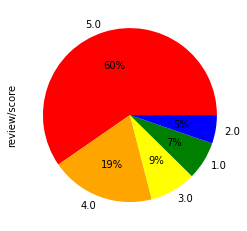

In [23]:
df['review/score'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['red','orange', 'yellow','green','blue'])

In [24]:
X = df[['review/text','review/summary']]
y = df[['review/score']]

To solve this problem we do some **undersampling** (removing observations from more numerous groups) to balance the scoring groups and better model performance:

In [25]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2062614 entries, 0 to 2999999
Data columns (total 1 columns):
 #   Column        Dtype  
---  ------        -----  
 0   review/score  float64
dtypes: float64(1)
memory usage: 31.5 MB


We decided to balance set by taking equal number of records for each score:

After undersampling the dataset is balanced and still contains enought data for machine learning techniques:

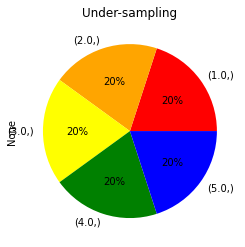

In [26]:
#rus = RandomUnderSampler(sampling_strategy='majority',random_state=RANDOM_SEED) # Numerical value

rus = RandomUnderSampler(
    sampling_strategy={
5.0    : CLASS_SIZE,
4.0    : CLASS_SIZE,
3.0    : CLASS_SIZE,
1.0    : CLASS_SIZE,
2.0    : CLASS_SIZE
    },
    random_state=RANDOM_SEED
)
# X_res, y_res = rus.fit_resample(X, y)

X_res, y_res = rus.fit_resample(X, y)
ax = y_res.value_counts().plot.pie(autopct='%1.0f%%', colors=['red','orange', 'yellow','green','blue'])
_ = ax.set_title("Under-sampling")

In [27]:
y_res.value_counts()

review/score
1.0             10000
2.0             10000
3.0             10000
4.0             10000
5.0             10000
dtype: int64

Let's see an examplary review - we can see that the texts require cleaning, e.g. removing punctuationa and stop words:

In [28]:
X_res.iloc[0]['review/text']

'The title promises a lot, instant juggling with new and improved juggling cubes. I returned both orders of this because the cubes never came with it.'

Let's prepare the dataset for modelling. **Notice: it'is worthy to put this initial transormations to pipeline just like we do with modelling steps.**

We turn reviews test to lowercase:

In [29]:
X_res['review/text'] = X_res['review/text'].apply(lambda x: " ".join(str(x).lower() for x in str(x).split()))
X_res['review/summary'] = X_res['review/summary'].apply(lambda x: " ".join(str(x).lower() for x in str(x).split()))

In [30]:
X_res['review/text'].head(20)

0     the title promises a lot, instant juggling wit...
1     princeton review claims to be the mecca of tes...
2     i am writing this review for the benefit of co...
3     after having finished a 1200 page copy of mail...
4     this book is horrible, it is too long, confusi...
5     this book made me want to run to the bathroom ...
6     i ordered this book on 7/28/09. my credit card...
7     don't believe amazon when they say you can hav...
8     don't waste your time with this book -- you'll...
9     this physics book &quot;helped&quot; me throug...
10    i have to add my voice to the chorus of don't ...
11    i always read classics among other things, i a...
12    after witnessing the emotional honesty of the ...
13    i grabbed this book with lot of enthusiasm, gi...
14    i give up. cornwell has turned to greed and is...
15    there are enough reviews on this product that ...
16    the movie sparked interest in the book. the pr...
17    that's the only way i can describe this bo

In [31]:
X_res['review/summary'].head(20)

0                                  2 strikes & your out
1                           not worth it!!!! get cliffs
2          not for the children of conservative parents
3                                      too much details
4                                 do not read this book
5                     the autobiography of a real loser
6                                     where is my book?
7                 overnight shipping -- what a rip off!
8                                  a fraudulent history
9                                              not good
10            absolutely maddening. terrible execution!
11                         wow.. this was really boring
12                             impenetrable showmanship
13             too many topics, too little information.
14                                  really, really bad.
15                     should you buy? -- pros and cons
16                                                price
17                               a major disappo

We keep only letters in the texts:

In [32]:
def keep_only_letters(text):
    pattern=r'[^a-zA-Z]'
    text=re.sub(pattern,' ',text)
    return text

X_res['review/text']=X_res['review/text'].apply(keep_only_letters)
X_res['review/summary']=X_res['review/summary'].apply(keep_only_letters)

In [33]:
X_res['review/text'].head(20)

0     the title promises a lot  instant juggling wit...
1     princeton review claims to be the mecca of tes...
2     i am writing this review for the benefit of co...
3     after having finished a      page copy of mail...
4     this book is horrible  it is too long  confusi...
5     this book made me want to run to the bathroom ...
6     i ordered this book on          my credit card...
7     don t believe amazon when they say you can hav...
8     don t waste your time with this book    you ll...
9     this physics book  quot helped quot  me throug...
10    i have to add my voice to the chorus of don t ...
11    i always read classics among other things  i a...
12    after witnessing the emotional honesty of the ...
13    i grabbed this book with lot of enthusiasm  gi...
14    i give up  cornwell has turned to greed and is...
15    there are enough reviews on this product that ...
16    the movie sparked interest in the book  the pr...
17    that s the only way i can describe this bo

In [34]:
X_res['review/summary'].head(20)

0                                    strikes   your out
1                           not worth it     get cliffs
2          not for the children of conservative parents
3                                      too much details
4                                 do not read this book
5                     the autobiography of a real loser
6                                     where is my book 
7                 overnight shipping    what a rip off 
8                                  a fraudulent history
9                                              not good
10            absolutely maddening  terrible execution 
11                         wow   this was really boring
12                             impenetrable showmanship
13             too many topics  too little information 
14                                  really  really bad 
15                     should you buy     pros and cons
16                                                price
17                               a major disappo

Tokenization step (division into words):

In [35]:
# nltk.download('punkt')

def tokenize(text: str):
    return nltk.word_tokenize(text)

X_res['token_text'] = X_res['review/text'].apply(lambda x: tokenize(x))
X_res['token_text_summary'] = X_res['review/summary'].apply(lambda x: tokenize(x))
X_res

,review/text,review/summary,token_text,token_text_summary
0,the title promises a lot instant juggling wit...,strikes your out,"[the, title, promises, a, lot, instant, juggli...","[strikes, your, out]"
1,princeton review claims to be the mecca of tes...,not worth it get cliffs,"[princeton, review, claims, to, be, the, mecca...","[not, worth, it, get, cliffs]"
2,i am writing this review for the benefit of co...,not for the children of conservative parents,"[i, am, writing, this, review, for, the, benef...","[not, for, the, children, of, conservative, pa..."
3,after having finished a page copy of mail...,too much details,"[after, having, finished, a, page, copy, of, m...","[too, much, details]"
4,this book is horrible it is too long confusi...,do not read this book,"[this, book, is, horrible, it, is, too, long, ...","[do, not, read, this, book]"
...,...,...,...,...
49995,typics problem,methods,"[typics, problem]",[methods]
49996,hey what more can you say about this book othe...,an absolute classic,"[hey, what, more, can, you, say, about, this, ...","[an, absolute, classic]"
49997,jerry emphasizes the positive aspects of each ...,a wonderfully positive and useful summary of t...,"[jerry, emphasizes, the, positive, aspects, of...","[a, wonderfully, positive, and, useful, summar..."
49998,i have several of dana carpender s low carb re...,long time low carber loves these cookbooks,"[i, have, several, of, dana, carpender, s, low...","[long, time, low, carber, loves, these, cookbo..."


Remove stopwords:

In [36]:
stop=stopwords.words('english')

In [37]:
def remove_stop(text: str):
    return [word for word in text if word not in stop]
X_res['nostop_text'] = X_res['token_text'].apply(lambda x: remove_stop(x))
X_res['nostop_text_summary'] = X_res['token_text_summary'].apply(lambda x: remove_stop(x))
X_res

,review/text,review/summary,token_text,token_text_summary,nostop_text,nostop_text_summary
0,the title promises a lot instant juggling wit...,strikes your out,"[the, title, promises, a, lot, instant, juggli...","[strikes, your, out]","[title, promises, lot, instant, juggling, new,...",[strikes]
1,princeton review claims to be the mecca of tes...,not worth it get cliffs,"[princeton, review, claims, to, be, the, mecca...","[not, worth, it, get, cliffs]","[princeton, review, claims, mecca, test, prep,...","[worth, get, cliffs]"
2,i am writing this review for the benefit of co...,not for the children of conservative parents,"[i, am, writing, this, review, for, the, benef...","[not, for, the, children, of, conservative, pa...","[writing, review, benefit, conservative, paren...","[children, conservative, parents]"
3,after having finished a page copy of mail...,too much details,"[after, having, finished, a, page, copy, of, m...","[too, much, details]","[finished, page, copy, mailer, quot, harlot, g...","[much, details]"
4,this book is horrible it is too long confusi...,do not read this book,"[this, book, is, horrible, it, is, too, long, ...","[do, not, read, this, book]","[book, horrible, long, confusing, flat, quot, ...","[read, book]"
...,...,...,...,...,...,...
49995,typics problem,methods,"[typics, problem]",[methods],"[typics, problem]",[methods]
49996,hey what more can you say about this book othe...,an absolute classic,"[hey, what, more, can, you, say, about, this, ...","[an, absolute, classic]","[hey, say, book, pure, classic, book, read, sc...","[absolute, classic]"
49997,jerry emphasizes the positive aspects of each ...,a wonderfully positive and useful summary of t...,"[jerry, emphasizes, the, positive, aspects, of...","[a, wonderfully, positive, and, useful, summar...","[jerry, emphasizes, positive, aspects, persona...","[wonderfully, positive, useful, summary, styles]"
49998,i have several of dana carpender s low carb re...,long time low carber loves these cookbooks,"[i, have, several, of, dana, carpender, s, low...","[long, time, low, carber, loves, these, cookbo...","[several, dana, carpender, low, carb, recipe, ...","[long, time, low, carber, loves, cookbooks]"


Stemming - keeping only stem of the words:

In [38]:
porter = nltk.PorterStemmer()
def stemer(text: str):
    return [porter.stem(word) for word in text]
X_res['stem_text'] = X_res['nostop_text'].apply(lambda x: stemer(x))
X_res['stem_text_summary'] = X_res['nostop_text_summary'].apply(lambda x: stemer(x))
X_res

def tokenizer(text):
    return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

Lematization - keeping of lemt of the words for better model performance:

In [39]:
nltk.download('omw-1.4')

lemat = nltk.WordNetLemmatizer()
def lematizer(text: str):
    return [lemat.lemmatize(word) for word in text]
X_res['lemat_text'] = X_res['nostop_text'].apply(lambda x: lematizer(x))
X_res['lemat_text_summary'] = X_res['nostop_text_summary'].apply(lambda x: lematizer(x))
X_res

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,review/text,review/summary,token_text,token_text_summary,nostop_text,nostop_text_summary,stem_text,stem_text_summary,lemat_text,lemat_text_summary
0,the title promises a lot instant juggling wit...,strikes your out,"[the, title, promises, a, lot, instant, juggli...","[strikes, your, out]","[title, promises, lot, instant, juggling, new,...",[strikes],"[titl, promis, lot, instant, juggl, new, impro...",[strike],"[title, promise, lot, instant, juggling, new, ...",[strike]
1,princeton review claims to be the mecca of tes...,not worth it get cliffs,"[princeton, review, claims, to, be, the, mecca...","[not, worth, it, get, cliffs]","[princeton, review, claims, mecca, test, prep,...","[worth, get, cliffs]","[princeton, review, claim, mecca, test, prep, ...","[worth, get, cliff]","[princeton, review, claim, mecca, test, prep, ...","[worth, get, cliff]"
2,i am writing this review for the benefit of co...,not for the children of conservative parents,"[i, am, writing, this, review, for, the, benef...","[not, for, the, children, of, conservative, pa...","[writing, review, benefit, conservative, paren...","[children, conservative, parents]","[write, review, benefit, conserv, parent, like...","[children, conserv, parent]","[writing, review, benefit, conservative, paren...","[child, conservative, parent]"
3,after having finished a page copy of mail...,too much details,"[after, having, finished, a, page, copy, of, m...","[too, much, details]","[finished, page, copy, mailer, quot, harlot, g...","[much, details]","[finish, page, copi, mailer, quot, harlot, gho...","[much, detail]","[finished, page, copy, mailer, quot, harlot, g...","[much, detail]"
4,this book is horrible it is too long confusi...,do not read this book,"[this, book, is, horrible, it, is, too, long, ...","[do, not, read, this, book]","[book, horrible, long, confusing, flat, quot, ...","[read, book]","[book, horribl, long, confus, flat, quot, sux,...","[read, book]","[book, horrible, long, confusing, flat, quot, ...","[read, book]"
...,...,...,...,...,...,...,...,...,...,...
49995,typics problem,methods,"[typics, problem]",[methods],"[typics, problem]",[methods],"[typic, problem]",[method],"[typics, problem]",[method]
49996,hey what more can you say about this book othe...,an absolute classic,"[hey, what, more, can, you, say, about, this, ...","[an, absolute, classic]","[hey, say, book, pure, classic, book, read, sc...","[absolute, classic]","[hey, say, book, pure, classic, book, read, sc...","[absolut, classic]","[hey, say, book, pure, classic, book, read, sc...","[absolute, classic]"
49997,jerry emphasizes the positive aspects of each ...,a wonderfully positive and useful summary of t...,"[jerry, emphasizes, the, positive, aspects, of...","[a, wonderfully, positive, and, useful, summar...","[jerry, emphasizes, positive, aspects, persona...","[wonderfully, positive, useful, summary, styles]","[jerri, emphas, posit, aspect, person, type, a...","[wonder, posit, use, summari, style]","[jerry, emphasizes, positive, aspect, personal...","[wonderfully, positive, useful, summary, style]"
49998,i have several of dana carpender s low carb re...,long time low carber loves these cookbooks,"[i, have, several, of, dana, carpender, s, low...","[long, time, low, carber, loves, these, cookbo...","[several, dana, carpender, low, carb, recipe, ...","[long, time, low, carber, loves, cookbooks]","[sever, dana, carpend, low, carb, recip, book,...","[long, time, low, carber, love, cookbook]","[several, dana, carpender, low, carb, recipe, ...","[long, time, low, carber, love, cookbook]"


Find statistics of words in reviews:


In [40]:
word_counter = X_res['lemat_text'].apply(lambda x: len(x))
print('Average number of workds in reviews: ' + str(word_counter.mean()))
print('Minimum number of workds in reviews: ' + str(word_counter.min()))
print('Maximum number of workds in reviews: ' + str(word_counter.max()))

Average number of workds in reviews: 77.91622
Minimum number of workds in reviews: 0
Maximum number of workds in reviews: 2466


Find statistics of words in reviews' summaries:

In [41]:
word_counter = X_res['lemat_text_summary'].apply(lambda x: len(x))
print('Average number of workds in reviews summries: ' + str(word_counter.mean()))
print('Minimum number of workds in reviews summaries: ' + str(word_counter.min()))
print('Maximum number of workds in reviews summaries: ' + str(word_counter.max()))

Average number of workds in reviews summries: 3.0223
Minimum number of workds in reviews summaries: 0
Maximum number of workds in reviews summaries: 16


Remove empty summaries:

In [42]:
X_res[X_res['lemat_text_summary'].map(lambda x: len(x)) == 0]

,review/text,review/summary,token_text,token_text_summary,nostop_text,nostop_text_summary,stem_text,stem_text_summary,lemat_text,lemat_text_summary
19,i wish there were negative stars for a review ...,don t do it,"[i, wish, there, were, negative, stars, for, a...","[don, t, do, it]","[wish, negative, stars, review, book, written,...",[],"[wish, neg, star, review, book, written, dark,...",[],"[wish, negative, star, review, book, written, ...",[]
38,what a pitty someone claims that the book h...,there is no there there,"[what, a, pitty, someone, claims, that, the, b...","[there, is, no, there, there]","[pitty, someone, claims, book, alot, good, inf...",[],"[pitti, someon, claim, book, alot, good, infor...",[],"[pitty, someone, claim, book, alot, good, info...",[]
415,i like julie garwood s book seriously i do b...,what the,"[i, like, julie, garwood, s, book, seriously, ...","[what, the]","[like, julie, garwood, book, seriously, one, b...",[],"[like, juli, garwood, book, serious, one, best...",[],"[like, julie, garwood, book, seriously, one, b...",[]
725,you are probably better off buying something a...,what the,"[you, are, probably, better, off, buying, some...","[what, the]","[probably, better, buying, something, textbook...",[],"[probabl, better, buy, someth, textbook, norto...",[],"[probably, better, buying, something, textbook...",[]
859,eragon is the worse book i ever read it just ...,no no no,"[eragon, is, the, worse, book, i, ever, read, ...","[no, no, no]","[eragon, worse, book, ever, read, stupid, awfu...",[],"[eragon, wors, book, ever, read, stupid, aw, b...",[],"[eragon, worse, book, ever, read, stupid, awfu...",[]
...,...,...,...,...,...,...,...,...,...,...
47784,in my work on domestic violence especially cy...,,"[in, my, work, on, domestic, violence, especia...",[],"[work, domestic, violence, especially, cyberst...",[],"[work, domest, violenc, especi, cyberstalk, bo...",[],"[work, domestic, violence, especially, cyberst...",[]
48412,this book should be required reading for all t...,this is how you do it,"[this, book, should, be, required, reading, fo...","[this, is, how, you, do, it]","[book, required, reading, thriller, writers, n...",[],"[book, requir, read, thriller, writer, new, ol...",[],"[book, required, reading, thriller, writer, ne...",[]
48838,in the rising tide jeff shaara continues to c...,you are there,"[in, the, rising, tide, jeff, shaara, continue...","[you, are, there]","[rising, tide, jeff, shaara, continues, chroni...",[],"[rise, tide, jeff, shaara, continu, chronicl, ...",[],"[rising, tide, jeff, shaara, continues, chroni...",[]
49538,ekman s work is key to everyone knowing the t...,more of the same,"[ekman, s, work, is, key, to, everyone, knowin...","[more, of, the, same]","[ekman, work, key, everyone, knowing, truth, a...",[],"[ekman, work, key, everyon, know, truth, alway...",[],"[ekman, work, key, everyone, knowing, truth, a...",[]


In [43]:
X_res['lemat_text_summary'] = X_res['lemat_text_summary'].apply(lambda x: ['empty'] if len(x) == 0 else x)

In [44]:
word_counter = X_res['lemat_text_summary'].apply(lambda x: len(x))
print('Average number of workds in reviews summries: ' + str(word_counter.mean()))
print('Minimum number of workds in reviews summaries: ' + str(word_counter.min()))
print('Maximum number of workds in reviews summaries: ' + str(word_counter.max()))

Average number of workds in reviews summries: 3.0277
Minimum number of workds in reviews summaries: 1
Maximum number of workds in reviews summaries: 16


Keep only first and last FIRST_WORDS_NUMBER words:

In [45]:
# FIRST_WORDS_NUMBER

def keep_only_first_words(text_list):
  return text_list[0:min(FIRST_WORDS_NUMBER, len(text_list))]

def keep_only_last_words(text_list):
  return text_list[:-min(FIRST_WORDS_NUMBER, len(text_list))]


X_res['first_words'] = X_res['lemat_text'].apply(lambda x: keep_only_first_words(x)) # + keep_only_last_words(x))
r = X_res['first_words'].iloc[0] 
print(r)
X_res['joined_words']= X_res['first_words'].str.join(' ')

['title', 'promise', 'lot', 'instant', 'juggling', 'new', 'improved', 'juggling', 'cube', 'returned', 'order', 'cube', 'never', 'came']


In [46]:
X_res['first_words']

0        [title, promise, lot, instant, juggling, new, ...
1        [princeton, review, claim, mecca, test, prep, ...
2        [writing, review, benefit, conservative, paren...
3        [finished, page, copy, mailer, quot, harlot, g...
4        [book, horrible, long, confusing, flat, quot, ...
                               ...                        
49995                                    [typics, problem]
49996    [hey, say, book, pure, classic, book, read, sc...
49997    [jerry, emphasizes, positive, aspect, personal...
49998    [several, dana, carpender, low, carb, recipe, ...
49999    [totally, engrossing, book, leave, speechless,...
Name: first_words, Length: 50000, dtype: object

Let's explore content of the best and the worst reviews and their summaries by visualizing them using word clouds:

In [47]:
def prep_reviews_score_n(score: int):
  reviews_score_n = list(X_res.loc[y_res['review/score']==score, 'first_words'].values)
  reviews_score_n = list(itertools.chain.from_iterable(reviews_score_n))
  reviews_score_n = ' '.join(reviews_score_n)
  return reviews_score_n

In [48]:
def prep_reviews_summaries_score_n(score: int):
  reviews_score_n = list(X_res.loc[y_res['review/score']==score, 'lemat_text_summary'].values)
  reviews_score_n = list(itertools.chain.from_iterable(reviews_score_n))
  reviews_score_n = ' '.join(reviews_score_n)
  return reviews_score_n

In [49]:
def show_words_cloud(reviews, description:str, score:int):
  wCloud = WordCloud().generate(reviews)
  plt.figure(figsize = (12, 8))
  plt.imshow(wCloud)
  plt.axis("off")
  plt.title(description + ' reviews (score = ' + str(score) + ')')
  plt.show()

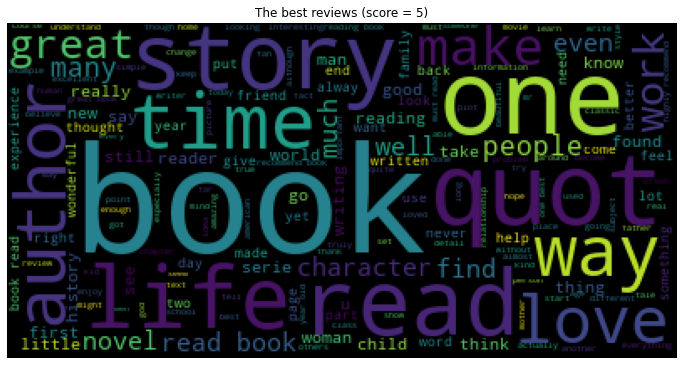

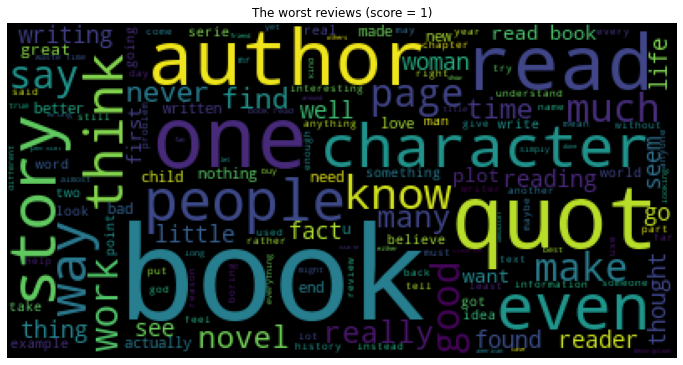

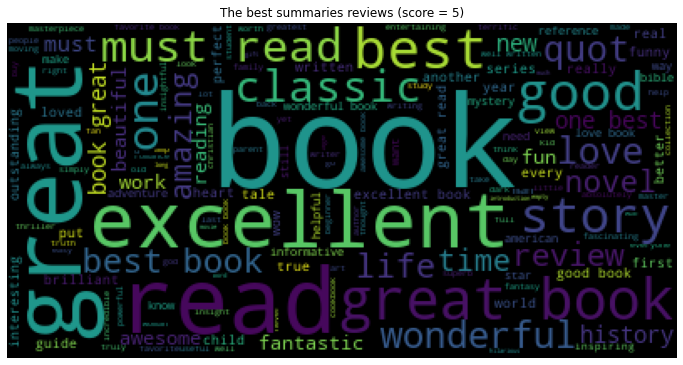

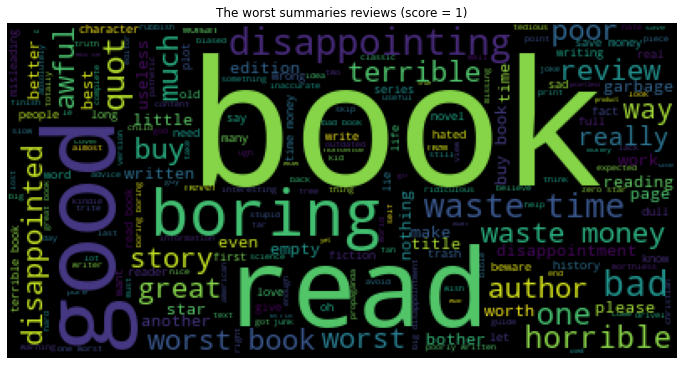

In [50]:
reviews_score_best = prep_reviews_score_n(5)
reviews_score_worst = prep_reviews_score_n(1)
reviews_score_sum_best = prep_reviews_summaries_score_n(5)
reviews_score_sum_worst = prep_reviews_summaries_score_n(1)
show_words_cloud(reviews_score_best , 'The best' , 5)
show_words_cloud(reviews_score_worst, 'The worst', 1)
show_words_cloud(reviews_score_sum_best , 'The best summaries' , 5)
show_words_cloud(reviews_score_sum_worst, 'The worst summaries', 1)

We can see that inspite of apparences that business domain is quite simple thee images of words for reviews are quite similar, so decision how to classify given review will not be straightforward. It's possible that n-grams would give more information. Not too many words have positive or negative conotation, they are neutral. Summaries give better picture of book score with marked by an assessment important words like **excellent/best/great/amazing for score 5** and **poor/disappointing/waste/terrible/horrible/worst for score 1**.

In [51]:
# X.shape, y_res.shape

Data for modeliing are chosen and are divided into train and test part. IMPORTANT DECISION: to make our models useful for automatic scoring of new reviews we take only one variable for modeling - review summary (other approaches could be taken like including price or full reviews):

In [52]:
def letters_only(x):
    return re.sub("[^a-zA-Z]"," ",str(x))

#X_res_3 = X_res['review/text'] #.apply(lambda x : letters_only(x))
#X_res_2 = X_res['review/text'].apply(lambda x : letters_only(x)) # X_res['lemat_text'].apply(lambda x : letters_only(x))
X_res_4 = X_res['first_words'].apply(lambda x : letters_only(x))
X_res_5 = X_res['joined_words']
X_res['joined_summary']= X_res['lemat_text_summary'].str.join(' ')
X_res_6 = X_res['joined_summary']

X_train, X_test, y_train, y_test = train_test_split(X_res_6 , y_res, test_size=0.25, random_state=RANDOM_SEED, stratify=y_res)

y_train['review/score'] = y_train['review/score'].astype(int)
y_test['review/score'] = y_test['review/score'].astype(int)

In [53]:
y_train.shape, X_train.shape

((37500, 1), (37500,))

In [54]:
X_train

27218                             informative
4663                                ok psycho
38639                  good book despite flaw
33207                      exotic interesting
35636                               good book
                         ...                 
44161                       wow guy know know
32893                            good kid age
12986    plot america full plot little action
27550                               good read
36788     dated useful audio upgrade handbook
Name: joined_summary, Length: 37500, dtype: object

In [55]:
y_test.shape, X_test.shape

((12500, 1), (12500,))

## Modelling

The Intial approach was to check base models without any hyperparameter optimization and no dimention reduction (PCA), which gave slightly better results than random for this set (which is 0.20). However ambition was much higher so pipelines with dimentionality reduction and cross validation were introduced and grid search to find the best hyperparameters. However results were still weak so we checked many availabe types of models to find better performing ones.

### Model - Decision Trees

Our pipelines for Decision Tree model and further models apart from Neural Network and BERT embedding approach are built on the following sequence:
1. words vectorization which produces sparse data
2. scaling (standarization)
3. dimentionality reduction - TruncatedSVD must be used instead of PCA for sparse data.
4. specific model, e.g. DecisionTreeClassifier

param_grid contains selected hyperparameters' for optimization.

In [ ]:
vect = TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None,
                        # max_features=10000,
                        # min_df=0.05,
                        # max_df=0.5
                      )

param_grid = [{
              'vect__ngram_range': [(1,1)], #,(1,2),(1,3)],
              'vect__max_features': [100, 1000, 5000],
              # 'vect__min_df': [0.01], #[0.001, 0.05, 0.1, 0.5],
              # 'vect__max_df': [0.99],#[0.1,0.5,0.75],
              # 'vect__stop_words': [stop], #None
              # 'vect__tokenizer': [tokenizer_porter], # tokenizer, 
               'svd__n_components' : [100, 500, 1000],
               'dt__max_depth': [5, 10, 20] 
              }
             ]

pipeline_dt = Pipeline([('vect', vect),
                        ('standardize', StandardScaler(with_mean=False)),
                        ('svd', TruncatedSVD(random_state=RANDOM_SEED)),
                        ('dt', DecisionTreeClassifier())])


gs_dt = GridSearchCV(pipeline_dt, param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)

Let us train our pipeline and see model scores for training (cross validation) and test dataset:

In [ ]:
gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_)
print('Cross validation train score: ' + str(gs_dt.best_score_))
clf = gs_dt.best_estimator_
print('Test accuracy (model score): ' + str(clf.score(X_test, y_test)))

Let us make prediction and see confucion matrix for various scores:

In [ ]:
y_test_predict = gs_dt.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

#### Model - Decision Trees - results discussions

We can see accuracy for training and test dataset is equal to 0.32 - model is not overfitted, but is certainly underfitted. Also, some of scoring classes perform better that others: f1-score for class score = 1 and score = 5 equals to 0.38 which indicates that extreme scoring is better recognized.

### Model - Random Forest

Another type of model that we use is model usually better performing than single decision trees - Random Forrest:

In [ ]:
vect = TfidfVectorizer(strip_accents=None, 
                        lowercase=True,#False, 
                        preprocessor=None)

param_grid = [{# 'vect__stop_words': [stop], #None
              # 'vect__tokenizer': [tokenizer_porter],
                'vect__ngram_range': [(1,1)], #,(1,2),(1,3)],
                'vect__max_features': [200], # 200, 500, 1000],
                'svd__n_components' : [100] , #200, 500, 1000],# [5,10, 20, 50] ,
                'rf__n_estimators': [200, 500, 1000], # [20, 50, 100,1000],
                'rf__max_depth': [20] # 50] #[5, 10, 20]
              }
             ]

pipeline_rf = Pipeline([('vect', vect),
                     ('standardize', StandardScaler(with_mean=False)),
                     ('svd', TruncatedSVD(random_state=RANDOM_SEED)),
                     ('rf', RandomForestClassifier())]) #))])

gs_rf = GridSearchCV(pipeline_rf, param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)

In [ ]:
gs_rf.fit(X_train, y_train)
print(gs_rf.best_params_)
print('Cross validation train score: ' + str(gs_rf.best_score_))
clf = gs_rf.best_estimator_
print('Test accuracy (model score): ' + str(clf.score(X_test, y_test)))

In [ ]:
y_test_predict = gs_rf.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

#### Model - Random Forest - results discussion

Cross validation train score is 0.32 and test accuracy (model score) is 0.32 which is coparable to Decision Tree model.

### Model - SVM

Support Vector Machine model training is very time consuming, so we don't try to prepare such model.

### Model XGBoost

XGBoost models give usually good results so we try it.

In [ ]:
vect = TfidfVectorizer(strip_accents=None, 
                        lowercase=True,#False, 
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1,1)],
              # 'vect__stop_words': [stop], #None
              # 'vect__tokenizer': [tokenizer_porter],
               'svd__n_components' : [5,10, 20, 50]
              }
             ]

pipeline_xgb = Pipeline([('vect', vect),
                     ('standardize', StandardScaler(with_mean=False)),
                     ('svd', TruncatedSVD(random_state=RANDOM_SEED)),
                     ('xgb', XGBClassifier())]) #]'liblinear'))])
#'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'

gs_xgb = GridSearchCV(pipeline_xgb, param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)

This type of model requires relabeling score from 1 to 5 (n) to 0 to 4 (n-1):

In [ ]:
y_train['review/score'] = y_train['review/score'].astype(int)
y_test['review/score'] = y_test['review/score'].astype(int)
le = LabelEncoder() # value : 0,...,n-1
y_train_relabeled = le.fit_transform(y_train)

le2 = LabelEncoder() # value : 0,...,n-1
y_test_relabeled = le2.fit_transform(y_test)

#y_train_relabeled

gs_xgb.fit(X_train, y_train_relabeled )

In [ ]:
print(gs_xgb.best_params_)
print('Cross validation train score: ' + str(gs_xgb.best_score_))
clf = gs_xgb.best_estimator_
print('Test accuracy (model score): ' + str(clf.score(X_test, y_test_relabeled)))

y_test_predict = gs_xgb.best_estimator_.predict(X_test)

#y_test_predict = y_test_predict.astype(int)

y_test_predict = le2.inverse_transform(y_test_predict)

print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))


#### Model - XGBoost - results discussion

Cross validation train score: 0.287
Test accuracy (model score): 0.295
This means that model is not overfitted, but is underfitted. It appeared suprisingly to give worse results than Decision Trees/Random Forest models.

### Model - Neural Networks

We create vectoried reprezentation of reviews summaries as an input for neural network model and prepare numpy reprezenation of our training and test datasets:

In [ ]:
vect = TfidfVectorizer(strip_accents=None, 
                        lowercase=True,#False, 
                        preprocessor=None)


X_train_nn = vect.fit_transform(X_train).toarray() 
X_test_nn = vect.fit_transform(X_test).toarray() 

In [ ]:
X_train_nn.shape

We introduce ealy stoping mechanism in order to avoid overfitting to our neural network model which has 5 dense layers with dropouts:

In [ ]:
early_stopping = EarlyStopping("val_accuracy", 
                               patience=5, 
                               restore_best_weights=True)
nn_model = Sequential()
nn_model.add(Dense(32, input_shape=(1,X_train_nn.shape[1]), activation= activations.relu))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation= activations.relu))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation= activations.relu))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation= activations.relu))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(6, activation= activations.softmax)) # this should be just 5, but it did not work with 5!
nn_model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics="accuracy") # categorical_accuracy") # 'accuracy')

This is structure of our neural network:

In [ ]:
nn_model.summary()

Let us check dimentions of our input dataset:

In [ ]:
X_train, X_train.shape

In [ ]:
y_train, y_train.shape

In [ ]:
X_train_tf = X_train_nn
X_train_tf = np.reshape(X_train_tf, (X_train_tf.shape[0],1,X_train_tf.shape[1]))
y_train_tf = tf.reshape(y_train, [y_train.shape[0], 1, y_train.shape[1]])

In [ ]:
y_train_tf, y_train_tf.shape

Let us train our neural network model:

In [ ]:
# nn_history = nn_model.fit(X_train_tf, y_train_tf, epochs = NUMBER_OF_EPOCHS, validation_split=0.3 )
nn_history = nn_model.fit(X_train_tf, y_train_tf, 
          epochs=NUMBER_OF_EPOCHS, 
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stopping])

In [ ]:
nn_history.history

In [ ]:
# X_test_tf = X_test
# X_test_tf = np.reshape(X_test_tf, (X_test_tf.shape[0],1,X_test_tf.shape[1]))
# #X_test_tf = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
# y_test_2 = to_categorical(y_test)

# #y_train_tf = to_categorical(y_train)
# #print(y_train_tf.shape[1])
# #y_train_tf = y_train.toarray()
# y_test_tf = tf.reshape(y_test, [y_test.shape[0], 1, y_test.shape[1]])

# X_test_tf.shape

In [ ]:
# y_pred = nn_model.predict(X_test)
# accuracy_score(y_test.argmax(1), y_pred.argmax(2))

nn_model.evaluate(X_train_nn, y_train)

In [ ]:
# print(metrics.classification_report(y_test_2.argmax(1), Y_pred.argmax(2)))

#### Model - Neural Networks - results discussion

The results for validatio dataset were not satisfactory, acurracy was less than 0.4.

### Logistic Regression

Wee try another simpler model - logistic regression:

In [ ]:
vect = TfidfVectorizer(strip_accents=None, 
                        lowercase=True,#False, 
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1,1)],
               #'vect__stop_words': [stop], #None
               'vect__tokenizer': [tokenizer_porter], # tokenizer, 
               'svd__n_components' : [20],
               'lr__penalty': ['l2'], # 'l1', 
               'lr__C': [1.0],
               'lr__solver': ['sag'] #,'lbfgs'] #, 'sag', 'lbfgs']
              }
             ]

pipeline_lr = Pipeline([('vect', vect), ('svd', TruncatedSVD(random_state=RANDOM_SEED)),
                     ('lr', LogisticRegression(multi_class='multinomial', random_state=RANDOM_SEED))]) #]'liblinear'))])
#'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'

gs_lr = GridSearchCV(pipeline_lr, param_grid, 
                           scoring='accuracy',
                           cv=5, verbose=3,
                           n_jobs=-1)

# Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

In [ ]:
gs_lr.fit(X_train, y_train)
print(gs_lr.best_params_)
print('Cross validation train score: ' + str(gs_lr.best_score_))
clf = gs_lr.best_estimator_
print('Test accuracy (model score): ' + str(clf.score(X_test, y_test)))

In [ ]:
y_test_predict = gs_lr.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

#### Model - Logistc Regression - results discussion

Cross-validation train score: is 0.29, while test accuracy (model score): 0.295 which is quite poor result in coparison to baseline.

### Embedings and  recursive Neural Networks (Wikipedia2Vec)

We use embedings - vector representations of words:

In [ ]:
y_train['review/score'] = y_train['review/score'].astype(int)

In [ ]:
y_test['review/score'] = y_test['review/score'].astype(int)

In [ ]:
train_labels_cat =  np.array(pd.get_dummies(y_train, columns=y_train.columns))
test_labels_cat =  np.array(pd.get_dummies(y_test, columns=y_test.columns))

In [ ]:
train_labels_cat

In [ ]:
!pip install wikipedia2vec

In [ ]:
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2

In [ ]:
!bunzip2 enwiki_20180420_100d.pkl.bz2

In [ ]:
from wikipedia2vec import Wikipedia2Vec

In [ ]:
! ls

We load the trained model:

In [ ]:
wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
len(sequences_train)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

We do padding - in order to make lengths of sequences uniform.

In [ ]:
sequence_train_padded = pad_sequences(sequences_train, maxlen=1000)

In [ ]:
sequences_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
sequence_test_padded = pad_sequences(sequences_test, maxlen=1000)

In [ ]:
words_count = len(tokenizer.word_counts) # tyle le. w słownku
print(words_count)

We prepare embedding matrix - representation of our reviews in the special form:

In [ ]:
embedding_matrix = np.zeros((words_count, 100))

In [ ]:
for key, value in tokenizer.word_index.items():
  try:
    embedding_matrix[value] = wiki2vec.get_word_vector(key)
  except:
    print(key)  

In [ ]:
from tensorflow.keras.layers import Embedding, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau

Again, we apply early stopping mechanism to avoid overfitting of the network:

In [ ]:
es = EarlyStopping(patience=5, verbose=True)
rlr = ReduceLROnPlateau(patience=2, verbose=True, factor=0.05)

The neural network has the follwing structure: 4 layers, one of them (hidden is recursive:

In [ ]:
model_nn2 = Sequential()
model_nn2.add(Embedding(words_count, 100, weights=[embedding_matrix], input_length=1000, trainable=False))
# model_nn2.add(GRU(64, return_sequences=True))
model_nn2.add(GRU(16))
model_nn2.add(Dense(16,activation=activations.relu))
model_nn2.add(Dense(5, activation=activations.softmax))
model_nn2.compile(loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_nn2.summary()

In [ ]:
train_labels_cat.shape

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history_nn2 = model_nn2.fit(sequence_train_padded, train_labels_cat, epochs=100, validation_split=0.1, callbacks=[rlr,es])

In [ ]:
plt.plot(history_nn2.history["accuracy"])
plt.plot(history_nn2.history["val_accuracy"])
plt.legend(["train","val"], loc="upper_rights")
plt.show()

In [ ]:
plt.plot(history_nn2.history["loss"])
plt.plot(history_nn2.history["val_loss"])
plt.legend(["train","val"], loc="upper_rights")
plt.show()

In [ ]:
model_nn2.evaluate(sequence_test_padded, test_labels_cat)

#### Model - Embedings and  recursive Neural Networks (Wikipedia2Vec) - results discussion

The result are not satisfactory, accuracy was less than 0.4.

### Model - BERT embeddings on SPARK

We are going to use widely recognized BERT embeddings on Spark distributed computation framework:

In [ ]:
!pip install -q pyspark==3.3.0  spark-nlp==4.2.0

In [ ]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [ ]:
pandasDF = pd.concat([X_res_5,y_res], axis=1)

sparkDF=spark.createDataFrame(pandasDF)

In [ ]:
# df = spark.read \
#       .option("header", True) \
#       .csv("/content/drive/MyDrive/Books_rating.csv")

#sparkDF.show(truncate=50)
sparkDF.printSchema()

In [ ]:
#train_df['category'] = train_df['review/score']
#val_df['category'] = val_df['review/score']

from pyspark.sql.types import DateType


df2 = sparkDF.withColumn('category',sparkDF['review/score'])

In [ ]:
df2.printSchema()

In [ ]:
df2.count()

In [ ]:
(train_df, val_df) = df2.randomSplit([0.7, 0.3], seed = RANDOM_SEED)
print("Training Dataset Count: " + str(train_df.count()))
print("Validation Dataset Count: " + str(val_df.count()))

We prepare piplne including document preparation, traind BERT embeddings and classifier:

In [ ]:
document = DocumentAssembler() \
.setInputCol("joined_words") \
.setOutputCol("document") \
.setCleanupMode("shrink")

bert = BertSentenceEmbeddings.pretrained('sent_bert_base_cased') \
.setInputCols("document") \
.setOutputCol("bert_sentence_embeddings") \
.setLazyAnnotator(False)

# the classes/labels/categories are in category column
classifierdl = ClassifierDLApproach()\
.setInputCols(["bert_sentence_embeddings"])\
.setOutputCol("class")\
.setLabelColumn("category")\
.setMaxEpochs(4)\
.setLr(0.001)\
.setBatchSize(64)\
.setEnableOutputLogs(True)
#.setOutputLogsPath('logs')

pipeline = Pipeline(
    stages = [
        document,
        bert,
        classifierdl
    ])

In [ ]:
%%time
pipelineModel = pipeline.fit(train_df)

In [ ]:
preds = pipelineModel.transform(val_df)

In [ ]:
preds.select('joined_words','category',"class.result").show(10, truncate=100)

In [ ]:
preds_df = preds.select('joined_words','category',"class.result").toPandas()

In [ ]:
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

In [ ]:
preds_df.head()

In [ ]:
preds_df['result2'] = preds_df['result'].apply(lambda x : float(x))

In [ ]:
from sklearn.metrics import classification_report

print (classification_report(preds_df['result2'], preds_df['category']))

####  Model - BERT embeddings on SPARK - results discussion

The result s were not also satisfactory. We obtained accuracy equal to 0.37 for test dataset, but for extreme scoring f1-score is higher than for others: for 5 - 0.5, and for 1 - 0.49. 

## Experiments

Experiments (apart from neural networks and embeddings) were based on grid search for optimal hyperparameters with cross-validation but all models were underfitted with accuracy between 0.3 to 0.37. It appeared that n-grams (n>1) did not contibute to better results for these data and also decresening number of analyzed words worsened accuracy. Also, better results were obtained for extreme scoring recignition (score 5 and 1 out of 5) which indicates text data polarization. Initially, experiments were conducted for full reviews text (variable text/review), but after dispoointing results and further analysis (words clouds) another variable was chosen for modeling as independent variable - summary of review (text/summery), which seemd to be more equivocal, but it also did not bring expected success (which would accuracy more than 0.5).

## Conclusions

The main conslusion is that these specific text data are difficult to model and find predictions for. They may contain a lot of metaphores, slang or colloquialisms, are very desciptive and not too much unequivocal. For limited set of data mailny due to RAM limitations we did not obtain good results. Although wide scope of models were tried, accuracy is not satisfactory for business applications of the obtained models. Other approaches could be undertaken: more variables could be used in models and additionaly some feature engineering could be introduced. Also, results would be better if we corrected spelling mistakes or introduced 2-values scoring (positive and negative). To be able to use significantly bigger amount of data we could use commencial Colab Pro environment. 

## Bibliography

1. Kodołamacz - Data Science PRO (40th edition), June - December 2022 - https://datasciencepro.kodolamacz.pl/
2. S. Raschka, "Python. Uczenie maszynowe", Pack Publishing, 2016
3. P. Szajowski, "Machine Learning i język Python. Kurs video. Praktyczne wykorzystanie popularnych bibliotek",https://helion.pl/ksiazki/machine-learning-i-jezyk-python-kurs-video-praktyczne-wykorzystanie-popularnych-bibliotek-piotr-szajowski,vprwyp.htm#format/w
4. Kodilla - https://kodilla.com/pl/bootcamp/data-science
5. Stackoverflow - https://stackoverflow.com/